In [258]:
#Using November 16-21.
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt
import re
from statistics import mean
from datetime import datetime
import numpy as np
from flask import Flask, jsonify

In [10]:
engine = create_engine('sqlite:///hawaii.db')
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurements = Base.classes.measurements
Stations = Base.classes.stations
session = Session(engine)

<function matplotlib.pyplot.show>

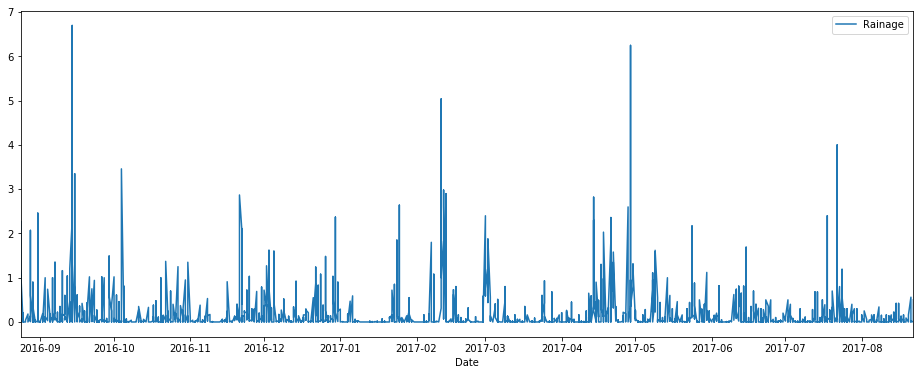

In [257]:
rows = (session
        .query(Measurements.date)
        .order_by(Measurements.date.desc())
        .all())
newest = max(rows)[0]
oldest = newest - relativedelta(years = 1)
past_year_prcp = (session
        .query(Measurements.date, Measurements.prcp)
        .filter(Measurements.date < newest)
        .filter(Measurements.date > oldest)
        .all())
past_year_df = pd.DataFrame.from_records(past_year_prcp, columns =["Date", "Rainage"])
past_year_df.set_index("Date", inplace= True)
%matplotlib inline
figure = past_year_df.plot(figsize=(16,6))
plt.show

In [97]:
past_year_df.describe()

,Rainage
count,2219.000000
mean,0.161875
std,0.441144
min,0.000000
25%,0.000000
50%,0.010000
75%,0.120000
max,6.700000


In [144]:
number_stations = (session
        .query(Stations.station)
        .distinct()
        .count())
station_list = list(session
        .query(Measurements.station)
        .distinct())
station_list = [s[0] for s in station_list]

station_obvs = []
for station in station_list:
    obvs = (session
        .query(Measurements.id)
        .filter(Measurements.station == station)
        .count())
    station_obvs.append(obvs)
station_obvs
station_freq = dict(zip(station_obvs, station_list))


In [150]:
station_df = pd.DataFrame(data = {"Station": station_list, "Observations": station_obvs})
station_df = station_df.sort_values(by = "Observations", ascending = False)

max(station_freq.keys())

2772

In [151]:
station_df

,Observations,Station
6,2772,USC00519281
0,2724,USC00519397
1,2709,USC00513117
5,2669,USC00519523
8,2612,USC00516128
2,2202,USC00514830
7,1979,USC00511918
3,1372,USC00517948
4,511,USC00518838


<function matplotlib.pyplot.show>

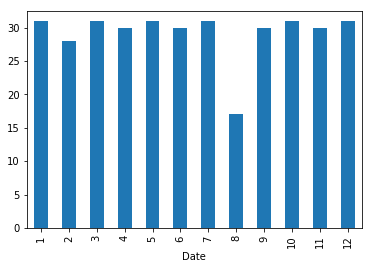

In [176]:
past_year_tobs = (session
        .query(Measurements.date, Measurements.tobs)
        .filter(Measurements.date < newest)
        .filter(Measurements.date > oldest)
        .filter(Measurements.station == 'USC00519281')
        .all())


df = pd.DataFrame.from_records(past_year_tobs, columns =["Date", "Hotness"])
df["Date"]= pd.to_datetime(df["Date"])
dates = pd.DataFrame(data = df["Date"])
%matplotlib inline
dates.groupby(dates["Date"].dt.month).count().plot(kind="bar", legend = False)
plt.show

In [213]:
def calc_temps(start, end):
    start = datetime.strptime(start, '%Y-%m-%d')
    end = datetime.strptime(end, '%Y-%m-%d')
    temp_query = (session
        .query(Measurements.tobs)
        .filter(Measurements.date < end)
        .filter(Measurements.date > start)
        .all())
    temps = [t[0] for t in temp_query]
    return (min(temps), max(temps), mean(temps))

In [214]:
trip_start = "2016-11-16"
trip_end = "2016-11-21"
calc_temps(trip_start, trip_end)

(71, 80, 75.4074074074074)

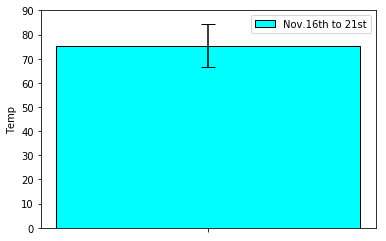

In [253]:
temps = calc_temps(trip_start, trip_end)
errors = [float(temps[0]), float(temps[1])]
barWidth = 0.6
bar = [temps[2]]
yer = (temps[0] - temps[1])
r1 = np.arange(len(bar))
r2 = [x + barWidth for x in r1]
plt.bar(r2, bar, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer, capsize=7, label='Nov.16th to 21st')
plt.xticks([r + barWidth for r in range(len(bar))], [''])
plt.ylabel('Temp')
plt.legend()
plt.ylim((0,90))
plt.show()



In [261]:
app = Flask(__name__)
@app.route('/api/v1.0/precipitation')
#was not sure if typo in instructions, followed directions exactly
def lastyr_temps():
    rows = (session
        .query(Measurements.date)
        .order_by(Measurements.date.desc())
        .all())
    newest = max(rows)[0]
    oldest = newest - relativedelta(years = 1)
    past_year_temp = (session
        .query(Measurements.date, Measurements.tobs)
        .filter(Measurements.date < newest)
        .filter(Measurements.date > oldest)
        .all())
    date_list = [i[0] for i in past_year_temp]
    tobs_list = [i[1] for i in past_year_temp]
    dict_tobs = dict(zip(date_list, tobs_list))
    return(jsonify(dict_tobs))

In [ ]:
@app.route('/api/v1.0/stations')
def stations():
    number_stations = (session
        .query(Stations.station)
        .distinct()
        .count())
    station_list = list(session
        .query(Measurements.station)
        .distinct())
    station_list = [s[0] for s in station_list]
    return(jsonify(station_list))

In [ ]:
@app.route('/api/v1.0/tobs')
def tobs():
    rows = (session
        .query(Measurements.date)
        .order_by(Measurements.date.desc())
        .all())
    newest = max(rows)[0]
    oldest = newest - relativedelta(years = 1)
    past_year_temp = (session
        .query(Measurements.tobs)
        .filter(Measurements.date < newest)
        .filter(Measurements.date > oldest)
        .all())
    tobs_list = [i[0] for i in past_year_temp]
    return(jsonify(tobs_list))

In [ ]:
@app.route('/api/v1.0/<start>')
def start_temps(start):
    start = datetime.strptime(start, '%Y-%m-%d')
    temp_query = (session
        .query(Measurements.tobs)
        .filter(Measurements.date >= start)
        .all())
    temps = [t[0] for t in temp_query]
    return(jsonify(min(temps), max(temps), mean(temps)))

@app.route('/api/v1.0/<start>/<end>')
def start_temps(start, end):
    start = datetime.strptime(start, '%Y-%m-%d')
    end = datetime.strptime(end, '%Y-%m-%d')
    temp_query = (session
        .query(Measurements.tobs)
        .filter(Measurements.date <= end)
        .filter(Measurements.date >= start)
        .all())
    temps = [t[0] for t in temp_query]
    return(jsonify(min(temps), max(temps), mean(temps)))